In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt
start='1986-01-01'
end='2021-01-23'
vfinx = pd.read_json('VFINX.json')
tnx = yf.download('^TNX', start=start, end=end, progress=False,auto_adjust=True)
vfinx.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,VIX_Close
1986-01-02,9.969467,9.969467,9.969467,9.969467,0,0.0,0,18.07
1986-01-03,10.035052,10.035052,10.035052,10.035052,0,0.0,0,17.96
1986-01-06,10.030688,10.030688,10.030688,10.030688,0,0.0,0,17.05
1986-01-07,10.179354,10.179354,10.179354,10.179354,0,0.0,0,17.39
1986-01-08,9.899508,9.899508,9.899508,9.899508,0,0.0,0,19.97


In [2]:
price = vfinx['Close']
price.name='price'
dividends = vfinx['Dividends']
dividends[dividends>0]

1986-03-27    0.180
1986-06-27    0.180
1986-09-30    0.180
1986-12-30    0.350
1987-03-27    0.180
              ...  
2019-12-20    1.365
2020-03-09    1.113
2020-06-26    1.355
2020-09-28    1.233
2020-12-21    1.311
Name: Dividends, Length: 141, dtype: float64

In [3]:
tnx_close = tnx['Close']
tnx_close.name = 'tnx_raw'
tnx_close

Ticker,^TNX
Date,
1986-01-02,9.040
1986-01-03,9.050
1986-01-06,9.070
1986-01-07,8.940
1986-01-08,9.130
...,...
2021-01-15,1.097
2021-01-19,1.092
2021-01-20,1.090


In [4]:
common_dates=price.index.intersection(tnx_close.index)
price_aligned=price .reindex(common_dates).ffill()
dividends_aligned = dividends.reindex(common_dates).fillna(0)
tnx_aligned=tnx_close.reindex(common_dates).ffill()

#доходность гос. облигаций
rf_daily = (tnx_aligned / 100) / 252
rf_daily = rf_daily['^TNX']
rf_daily

1986-01-02    0.000359
1986-01-03    0.000359
1986-01-06    0.000360
1986-01-07    0.000355
1986-01-08    0.000362
                ...   
2021-01-15    0.000044
2021-01-19    0.000043
2021-01-20    0.000043
2021-01-21    0.000044
2021-01-22    0.000043
Name: ^TNX, Length: 8791, dtype: float64

In [5]:
data=pd.DataFrame({
    'Price': price_aligned,
    'Dividends': dividends_aligned,
    'RF_Rate': rf_daily
})
data.head()

,Price,Dividends,RF_Rate
1986-01-02,9.969467,0.0,0.000359
1986-01-03,10.035052,0.0,0.000359
1986-01-06,10.030688,0.0,0.000360
1986-01-07,10.179354,0.0,0.000355
1986-01-08,9.899508,0.0,0.000362


In [80]:
# АНАЛИЗ ВРЕМЕННЫХ РЯДОВ - 15+ ПРИЗНАКОВ
def create_time_series_features(df, price_col='Price'):
    df = df.copy()
    
    # 1. Трендовые компоненты
    df['SMA_50'] = df[price_col].rolling(50).mean()
    df['SMA_200'] = df[price_col].rolling(200).mean()
    df['EMA_21'] = df[price_col].ewm(span=21).mean()
    
    # 2. Моментум и скорость изменения
    df['Returns_1D'] = df[price_col].pct_change()
    df['Returns_1M'] = df[price_col].pct_change(21)
    df['Returns_3M'] = df[price_col].pct_change(63)
    df['Returns_6M'] = df[price_col].pct_change(126)
    df['Returns_1Y'] = df[price_col].pct_change(252)
    
    # 3. Волатильность (разные периоды)
    df['Volatility_1M'] = df['Returns_1D'].rolling(21).std() * np.sqrt(252)
    df['Volatility_3M'] = df['Returns_1D'].rolling(63).std() * np.sqrt(252)
    df['Volatility_1Y'] = df['Returns_1D'].rolling(252).std() * np.sqrt(252)
    
    # 4. Относительные уровни (Z-score)
    df['Z_Score_1Y'] = (df[price_col] - df[price_col].rolling(252).mean()) / df[price_col].rolling(252).std()
    
    # 5. Проценты от экстремумов
    df['Pct_From_1Y_High'] = df[price_col] / df[price_col].rolling(252).max() - 1
    df['Pct_From_1Y_Low'] = df[price_col] / df[price_col].rolling(252).min() - 1
    
    # 6. Отношения скользящих средних
    df['MA_Ratio_50_200'] = df['SMA_50'] / df['SMA_200']
    
    return df
data_enhanced = create_time_series_features(data)
data_clean = data_enhanced.dropna().copy()

print(f"Создано {len([col for col in data_clean.columns if col not in ['Price', 'Dividends', 'RF_Rate']])} признаков временных рядов")
data_clean

Создано 15 признаков временных рядов


,Price,Dividends,RF_Rate,SMA_50,SMA_200,EMA_21,Returns_1D,Returns_1M,Returns_3M,Returns_6M,Returns_1Y,Volatility_1M,Volatility_3M,Volatility_1Y,Z_Score_1Y,Pct_From_1Y_High,Pct_From_1Y_Low,MA_Ratio_50_200
1987-01-07,11.589255,0.0,0.000280,11.740023,11.637767,11.457488,0.009862,-0.057340,0.019272,-0.017384,0.162475,0.290688,0.201146,0.167439,0.333323,-0.067833,0.195508,1.008787
1987-01-08,11.675273,0.0,0.000279,11.741572,11.639496,11.477286,0.007422,-0.050689,0.021622,0.000056,0.163449,0.292630,0.201420,0.167471,0.465389,-0.060914,0.204382,1.008770
1987-01-09,11.743179,0.0,0.000278,11.743854,11.642309,11.501458,0.005816,0.026362,0.029173,0.000554,0.170725,0.160718,0.201666,0.167547,0.569762,-0.055452,0.211387,1.008722
1987-01-12,11.815613,0.0,0.000280,11.747050,11.644981,11.530018,0.006168,0.025888,0.025491,0.006346,0.160743,0.160532,0.201121,0.167037,0.682568,-0.049626,0.218859,1.008765
1987-01-13,11.797502,0.0,0.000282,11.748276,11.647715,11.554335,-0.001533,0.035554,0.027901,0.007847,0.191726,0.154811,0.200970,0.164646,0.647738,-0.051083,0.216990,1.008634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-15,347.940002,0.0,0.000044,338.144771,302.923109,345.775566,-0.007191,0.021117,0.085880,0.177518,0.154965,0.103980,0.155672,0.345518,1.599138,-0.014641,0.706831,1.116273
2021-01-19,350.779999,0.0,0.000043,338.823252,303.525185,346.230514,0.008162,0.027619,0.094607,0.177247,0.159886,0.106881,0.156242,0.345583,1.672502,-0.006598,0.720763,1.116294
2021-01-20,355.670013,0.0,0.000043,339.475011,304.168992,347.088650,0.013940,0.035929,0.128280,0.191635,0.179162,0.114616,0.153932,0.345814,1.805881,0.000000,0.744751,1.116074
2021-01-21,355.809998,0.0,0.000044,340.132159,304.733761,347.881500,0.000394,0.039927,0.123399,0.185287,0.179242,0.113200,0.153858,0.345814,1.792029,0.000000,0.745437,1.116162


In [88]:
# СИСТЕМА ПРИНЯТИЯ РЕШЕНИЙ 

def calculate_allocation(row):
    # 1. Трендовый сигнал (35% веса)
    trend_score = 0
    if not pd.isna(row['SMA_50']) and not pd.isna(row['SMA_200']):
        if row['SMA_50'] > row['SMA_200']:
            trend_score += 0.25
        if row['EMA_21'] > row['SMA_200']:
            trend_score += 0.10
    
    # 2. Моментум сигнал (30% веса)
    momentum_score = 0
    if not pd.isna(row['Returns_1M']):
        if row['Returns_1M'] > 0:
            momentum_score += 0.10
        if row['Returns_3M'] > 0:
            momentum_score += 0.10
        if row['Returns_6M'] > 0:
            momentum_score += 0.10
    
    # 3. Волатильность/риск сигнал (20% веса)
    risk_score = 1.0
    if not pd.isna(row['Volatility_1Y']):
        vol_quantile_80 = data_clean['Volatility_1Y'].quantile(0.8)
        vol_quantile_60 = data_clean['Volatility_1Y'].quantile(0.6)
        if row['Volatility_1Y'] > vol_quantile_80:
            risk_score -= 0.3
        elif row['Volatility_1Y'] > vol_quantile_60:
            risk_score -= 0.15
    
    # 4. Ценовой сигнал (15% веса)
    price_score = 0
    if not pd.isna(row['Z_Score_1Y']):
        if row['Z_Score_1Y'] < -1.0:  
            price_score += 0.15
        elif row['Z_Score_1Y'] < -0.5: 
            price_score += 0.10
        elif row['Z_Score_1Y'] > 2.0:  
            price_score -= 0.15
        elif row['Z_Score_1Y'] > 1.5: 
            price_score -= 0.10
        else:
            price_score += 0.05  
    
    composite_score = (
        (trend_score / 0.35) * 0.35 +
        (momentum_score / 0.30) * 0.30 +
        risk_score * 0.20 +
        ((price_score + 0.15) / 0.15) * 0.15
    )
    
    if composite_score >= 0.8:
        return 1.0  # 100% в акции
    elif composite_score >= 0.7:
        return 0.8  # 80% в акции
    elif composite_score >= 0.6:
        return 0.7  # 70% в акции
    elif composite_score >= 0.5:
        return 0.6  # 60% в акции
    elif composite_score >= 0.4:
        return 0.4  # 40% в акции
    elif composite_score >= 0.3:
        return 0.2  # 20% в акции
    else:
        return 0   # полностью в кэше

data_clean['Target_Allocation'] = data_clean.apply(calculate_allocation, axis=1)
data_clean

,Price,Dividends,RF_Rate,SMA_50,SMA_200,EMA_21,Returns_1D,Returns_1M,Returns_3M,Returns_6M,...,Volatility_3M,Volatility_1Y,Z_Score_1Y,Pct_From_1Y_High,Pct_From_1Y_Low,MA_Ratio_50_200,Target_Allocation,Rebalance_Freq,Daily_Allocation,Daily_Freq
1987-01-07,11.589255,0.0,0.000280,11.740023,11.637767,11.457488,0.009862,-0.057340,0.019272,-0.017384,...,0.201146,0.167439,0.333323,-0.067833,0.195508,1.008787,0.8,2W,0.8,2W
1987-01-08,11.675273,0.0,0.000279,11.741572,11.639496,11.477286,0.007422,-0.050689,0.021622,0.000056,...,0.201420,0.167471,0.465389,-0.060914,0.204382,1.008770,1.0,2W,1.0,2W
1987-01-09,11.743179,0.0,0.000278,11.743854,11.642309,11.501458,0.005816,0.026362,0.029173,0.000554,...,0.201666,0.167547,0.569762,-0.055452,0.211387,1.008722,1.0,2W,1.0,2W
1987-01-12,11.815613,0.0,0.000280,11.747050,11.644981,11.530018,0.006168,0.025888,0.025491,0.006346,...,0.201121,0.167037,0.682568,-0.049626,0.218859,1.008765,1.0,2W,1.0,2W
1987-01-13,11.797502,0.0,0.000282,11.748276,11.647715,11.554335,-0.001533,0.035554,0.027901,0.007847,...,0.200970,0.164646,0.647738,-0.051083,0.216990,1.008634,1.0,2W,1.0,2W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-15,347.940002,0.0,0.000044,338.144771,302.923109,345.775566,-0.007191,0.021117,0.085880,0.177518,...,0.155672,0.345518,1.599138,-0.014641,0.706831,1.116273,1.0,M,1.0,M
2021-01-19,350.779999,0.0,0.000043,338.823252,303.525185,346.230514,0.008162,0.027619,0.094607,0.177247,...,0.156242,0.345583,1.672502,-0.006598,0.720763,1.116294,1.0,M,1.0,M
2021-01-20,355.670013,0.0,0.000043,339.475011,304.168992,347.088650,0.013940,0.035929,0.128280,0.191635,...,0.153932,0.345814,1.805881,0.000000,0.744751,1.116074,1.0,M,1.0,M
2021-01-21,355.809998,0.0,0.000044,340.132159,304.733761,347.881500,0.000394,0.039927,0.123399,0.185287,...,0.153858,0.345814,1.792029,0.000000,0.745437,1.116162,1.0,M,1.0,M


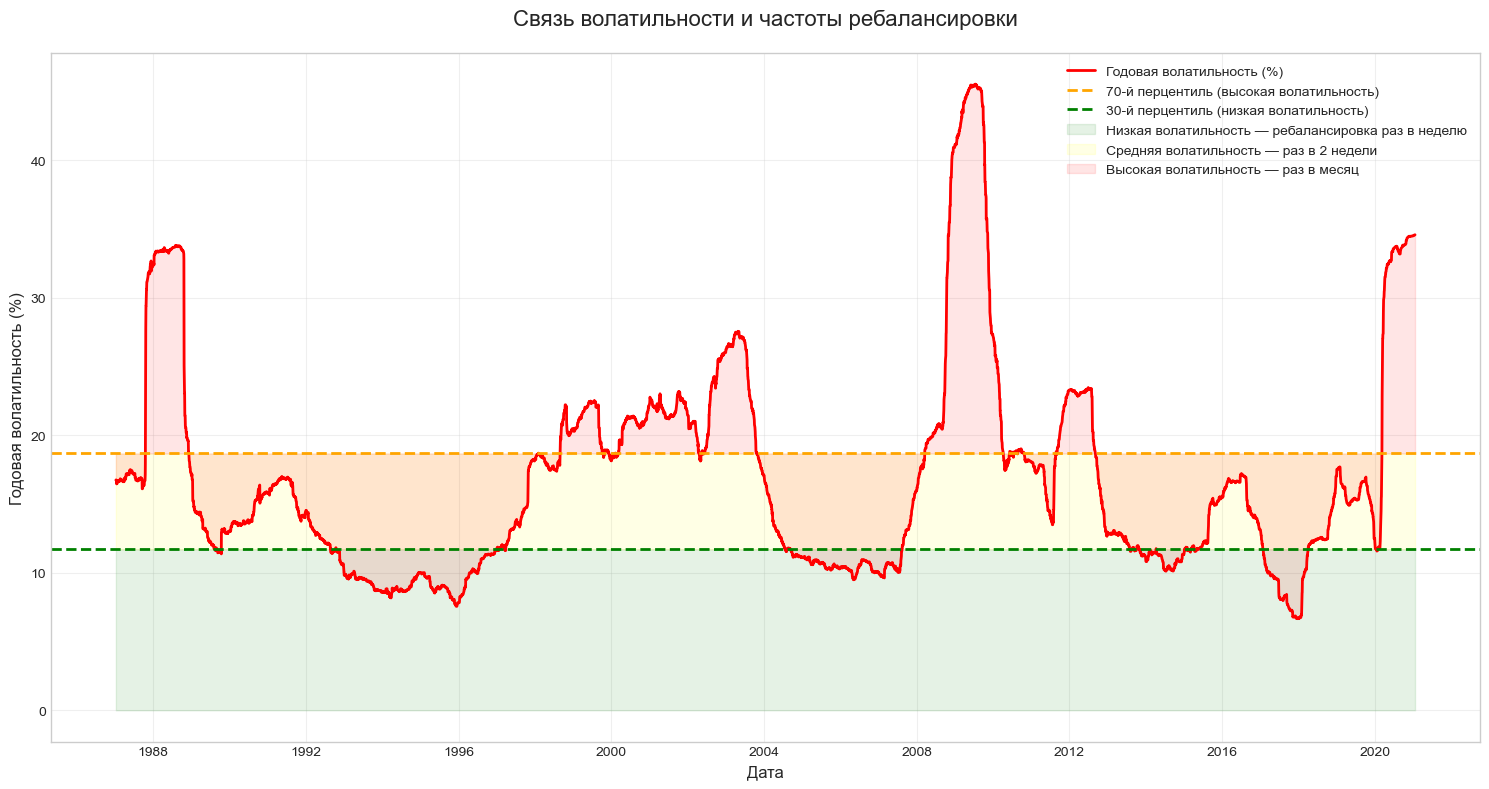

In [82]:
# АДАПТИВНАЯ ЧАСТОТА РЕБАЛАНСИРОВКИ

def get_rebalance_freq(row):
    if pd.isna(row['Volatility_1Y']):
        return 'M'  # По умолчанию раз в месяц
    
    vol_quantile_70 = data_clean['Volatility_1Y'].quantile(0.7)
    vol_quantile_30 = data_clean['Volatility_1Y'].quantile(0.3)
    
    if row['Volatility_1Y'] > vol_quantile_70:
        return 'M'  # Высокая волатильность - раз в месяц
    elif row['Volatility_1Y'] < vol_quantile_30:
        return 'W'  # Низкая волатильность - раз в неделю
    else:
        return '2W'  # Средняя волатильность - раз в 2 недели

data_clean['Rebalance_Freq'] = data_clean.apply(get_rebalance_freq, axis=1)
plt.figure(figsize=(15, 8))

plt.plot(data_clean.index, data_clean['Volatility_1Y'] * 100, color='red', label='Годовая волатильность (%)', linewidth=2)

vol_quantile_70 = data_clean['Volatility_1Y'].quantile(0.7)
vol_quantile_30 = data_clean['Volatility_1Y'].quantile(0.3)

plt.axhline(vol_quantile_70 * 100, color='orange', linestyle='--', linewidth=2, label='70-й перцентиль (высокая волатильность)')
plt.axhline(vol_quantile_30 * 100, color='green', linestyle='--', linewidth=2, label='30-й перцентиль (низкая волатильность)')

plt.fill_between(data_clean.index, 0, vol_quantile_30 * 100, color='green', alpha=0.1, label='Низкая волатильность — ребалансировка раз в неделю')
plt.fill_between(data_clean.index, vol_quantile_30 * 100, vol_quantile_70 * 100, color='yellow', alpha=0.1, label='Средняя волатильность — раз в 2 недели')
plt.fill_between(data_clean.index, vol_quantile_70 * 100, data_clean['Volatility_1Y'] * 100, color='red', alpha=0.1, label='Высокая волатильность — раз в месяц')

plt.title('Связь волатильности и частоты ребалансировки', fontsize=16, pad=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Годовая волатильность (%)', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [83]:
# решения только по пятницам
weekly_decisions = data_clean['Target_Allocation'].resample('W-FRI').last()
daily_allocation = data_clean['Target_Allocation'].reindex(data_clean.index)
daily_allocation = daily_allocation.ffill()
data_clean['Daily_Allocation'] = daily_allocation

weekly_freq = data_clean['Rebalance_Freq'].resample('W-FRI').last()
daily_freq = data_clean['Rebalance_Freq'].reindex(data_clean.index)
daily_freq = daily_freq.ffill()
data_clean['Daily_Freq'] = daily_freq

data_clean

,Price,Dividends,RF_Rate,SMA_50,SMA_200,EMA_21,Returns_1D,Returns_1M,Returns_3M,Returns_6M,...,Volatility_3M,Volatility_1Y,Z_Score_1Y,Pct_From_1Y_High,Pct_From_1Y_Low,MA_Ratio_50_200,Target_Allocation,Rebalance_Freq,Daily_Allocation,Daily_Freq
1987-01-07,11.589255,0.0,0.000280,11.740023,11.637767,11.457488,0.009862,-0.057340,0.019272,-0.017384,...,0.201146,0.167439,0.333323,-0.067833,0.195508,1.008787,0.8,2W,0.8,2W
1987-01-08,11.675273,0.0,0.000279,11.741572,11.639496,11.477286,0.007422,-0.050689,0.021622,0.000056,...,0.201420,0.167471,0.465389,-0.060914,0.204382,1.008770,1.0,2W,1.0,2W
1987-01-09,11.743179,0.0,0.000278,11.743854,11.642309,11.501458,0.005816,0.026362,0.029173,0.000554,...,0.201666,0.167547,0.569762,-0.055452,0.211387,1.008722,1.0,2W,1.0,2W
1987-01-12,11.815613,0.0,0.000280,11.747050,11.644981,11.530018,0.006168,0.025888,0.025491,0.006346,...,0.201121,0.167037,0.682568,-0.049626,0.218859,1.008765,1.0,2W,1.0,2W
1987-01-13,11.797502,0.0,0.000282,11.748276,11.647715,11.554335,-0.001533,0.035554,0.027901,0.007847,...,0.200970,0.164646,0.647738,-0.051083,0.216990,1.008634,1.0,2W,1.0,2W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-15,347.940002,0.0,0.000044,338.144771,302.923109,345.775566,-0.007191,0.021117,0.085880,0.177518,...,0.155672,0.345518,1.599138,-0.014641,0.706831,1.116273,1.0,M,1.0,M
2021-01-19,350.779999,0.0,0.000043,338.823252,303.525185,346.230514,0.008162,0.027619,0.094607,0.177247,...,0.156242,0.345583,1.672502,-0.006598,0.720763,1.116294,1.0,M,1.0,M
2021-01-20,355.670013,0.0,0.000043,339.475011,304.168992,347.088650,0.013940,0.035929,0.128280,0.191635,...,0.153932,0.345814,1.805881,0.000000,0.744751,1.116074,1.0,M,1.0,M
2021-01-21,355.809998,0.0,0.000044,340.132159,304.733761,347.881500,0.000394,0.039927,0.123399,0.185287,...,0.153858,0.345814,1.792029,0.000000,0.745437,1.116162,1.0,M,1.0,M


In [87]:
# Симуляция торгового портфеля

def simulate_portfolio(data, dividends, initial_capital=10000):
    
    portfolio = pd.DataFrame(index=data.index)
    portfolio['Allocation'] = data['Daily_Allocation']
    portfolio['Rebalance_Freq'] = data['Daily_Freq']
    portfolio['Price'] = data['Price']
    portfolio['Dividends'] = dividends
    
    portfolio['Shares'] = 0.0
    portfolio['Cash'] = float(initial_capital)
    portfolio['Total_Value'] = float(initial_capital)
    portfolio['Last_Rebalance'] = data.index[0]
    
    # Начинаем с 252 дня (после того как накопились все индикаторы)
    start_idx = 252
    initial_allocation = portfolio['Allocation'].iloc[start_idx]
    initial_investment = initial_capital * initial_allocation
    portfolio.loc[data.index[start_idx], 'Shares'] = initial_investment / data['Price'].iloc[start_idx]
    portfolio.loc[data.index[start_idx], 'Cash'] = initial_capital - initial_investment
    portfolio.loc[data.index[start_idx], 'Total_Value'] = initial_capital
    portfolio.loc[data.index[start_idx], 'Last_Rebalance'] = data.index[start_idx]

    accumulated_dividends = 0.0
    rebalance_count = 0
    
    
    for i in range(start_idx + 1, len(portfolio)):
        current_date = portfolio.index[i]
        prev_date = portfolio.index[i-1]
        
        # Берем данные с предыдущего дня
        current_shares = portfolio.loc[prev_date, 'Shares']
        current_cash = portfolio.loc[prev_date, 'Cash']
        current_price = portfolio.loc[current_date, 'Price']
        current_dividend = portfolio.loc[current_date, 'Dividends']
        last_rebalance = portfolio.loc[prev_date, 'Last_Rebalance']
        current_freq = portfolio.loc[current_date, 'Rebalance_Freq']
        
        # Собираем дивиденды
        dividend_income = current_shares * current_dividend
        accumulated_dividends += dividend_income
        
        # Проверяем нужно ли ребалансировать
        days_since_rebalance = (current_date - last_rebalance).days
        need_rebalance = False
        
        if current_date.weekday() == 4:  # Только по пятницам
            if current_freq == 'W' and days_since_rebalance >= 7:
                need_rebalance = True
            elif current_freq == '2W' and days_since_rebalance >= 14:
                need_rebalance = True
            elif current_freq == 'M' and days_since_rebalance >= 30:
                need_rebalance = True
        
        # Ребалансировка
        if need_rebalance:
            rebalance_count += 1
            
            # Добавляем накопленные дивиденды
            current_cash += accumulated_dividends
            accumulated_dividends = 0.0
            
            # Получаем целевую аллокацию
            target_alloc = portfolio.loc[current_date, 'Allocation']
            
            # Текущая общая стоимость
            current_value = current_shares * current_price + current_cash
            
            # Сколько должно быть в акциях
            target_equity_value = current_value * target_alloc
            
            # Сколько сейчас в акциях
            current_equity_value = current_shares * current_price
            
            # Насколько нужно изменить позицию
            trade_value = target_equity_value - current_equity_value
            
            
            if trade_value > 0:  # Нужно купить
                max_affordable = current_cash
                actual_trade_value = min(trade_value, max_affordable)
                shares_to_buy = actual_trade_value / current_price
                current_shares += shares_to_buy
                current_cash -= actual_trade_value
            else:  # Нужно продать
                shares_to_sell = min(current_shares, abs(trade_value) / current_price)
                current_shares -= shares_to_sell
                current_cash += shares_to_sell * current_price
            
            portfolio.loc[current_date, 'Last_Rebalance'] = current_date
        else:
            portfolio.loc[current_date, 'Last_Rebalance'] = last_rebalance
        
        # Сохраняем результаты на текущий день
        portfolio.loc[current_date, 'Shares'] = current_shares
        portfolio.loc[current_date, 'Cash'] = current_cash
        portfolio.loc[current_date, 'Total_Value'] = current_shares * current_price + current_cash
    
    print(f"Симуляция завершена. Проведено ребалансировок: {rebalance_count}")
    return portfolio

portfolio_results = simulate_portfolio(data_clean, data_clean['Dividends'])

Симуляция завершена. Проведено ребалансировок: 944


In [101]:
#Расчет метрик эффективности

def calculate_performance_metrics(portfolio_data, risk_free_rate, benchmark_prices, start_idx=252):
    
    # Обрезаем данные до start_idx
    portfolio_data = portfolio_data.iloc[start_idx:]
    benchmark_prices = benchmark_prices.iloc[start_idx:]
    
    # Доходности стратегии
    strategy_returns = portfolio_data['Total_Value'].pct_change().dropna()
    
    # CAGR
    years = len(strategy_returns) / 252
    total_return = portfolio_data['Total_Value'].iloc[-1] / portfolio_data['Total_Value'].iloc[0] - 1
    cagr = (1 + total_return) ** (1/years) - 1
    
    # Волатильность
    volatility = strategy_returns.std() * np.sqrt(252)
    
    # Коэффициент Шарпа
    excess_returns = strategy_returns - risk_free_rate.reindex(strategy_returns.index).fillna(0)
    sharpe_ratio = excess_returns.mean() * 252 / volatility
    
    # Максимальная просадка
    cumulative = (1 + strategy_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Buy & Hold сравнение
    bh_cagr = 0.109
    
    return {
        'CAGR': cagr,
        'Volatility': volatility,
        'Sharpe_Ratio': sharpe_ratio,
        'Max_Drawdown': max_drawdown,
        'BuyHold_CAGR': bh_cagr,
        'CAGR_Difference': cagr - bh_cagr,
        'Final_Value': portfolio_data['Total_Value'].iloc[-1],
        'Total_Return': total_return,
    }

# Расчет метрик
metrics = calculate_performance_metrics(
    portfolio_results, 
    rf_daily,
    data_clean['Price']
)

print("РЕЗУЛЬТАТЫ СТРАТЕГИИ:")
print(f"Конечная стоимость: ${metrics['Final_Value']:,.2f}")
print(f"CAGR стратегии: {metrics['CAGR']:.2%}")
print(f"CAGR Buy & Hold: {metrics['BuyHold_CAGR']:.2%}")
print(f"Разница в CAGR: {metrics['CAGR_Difference']:.2%}")
print(f"Волатильность: {metrics['Volatility']:.2%}")
print(f"Коэффициент Шарпа: {metrics['Sharpe_Ratio']:.2f}")

РЕЗУЛЬТАТЫ СТРАТЕГИИ:
Конечная стоимость: $672,189.92
CAGR стратегии: 13.65%
CAGR Buy & Hold: 10.90%
Разница в CAGR: 2.75%
Волатильность: 14.57%
Коэффициент Шарпа: 0.63


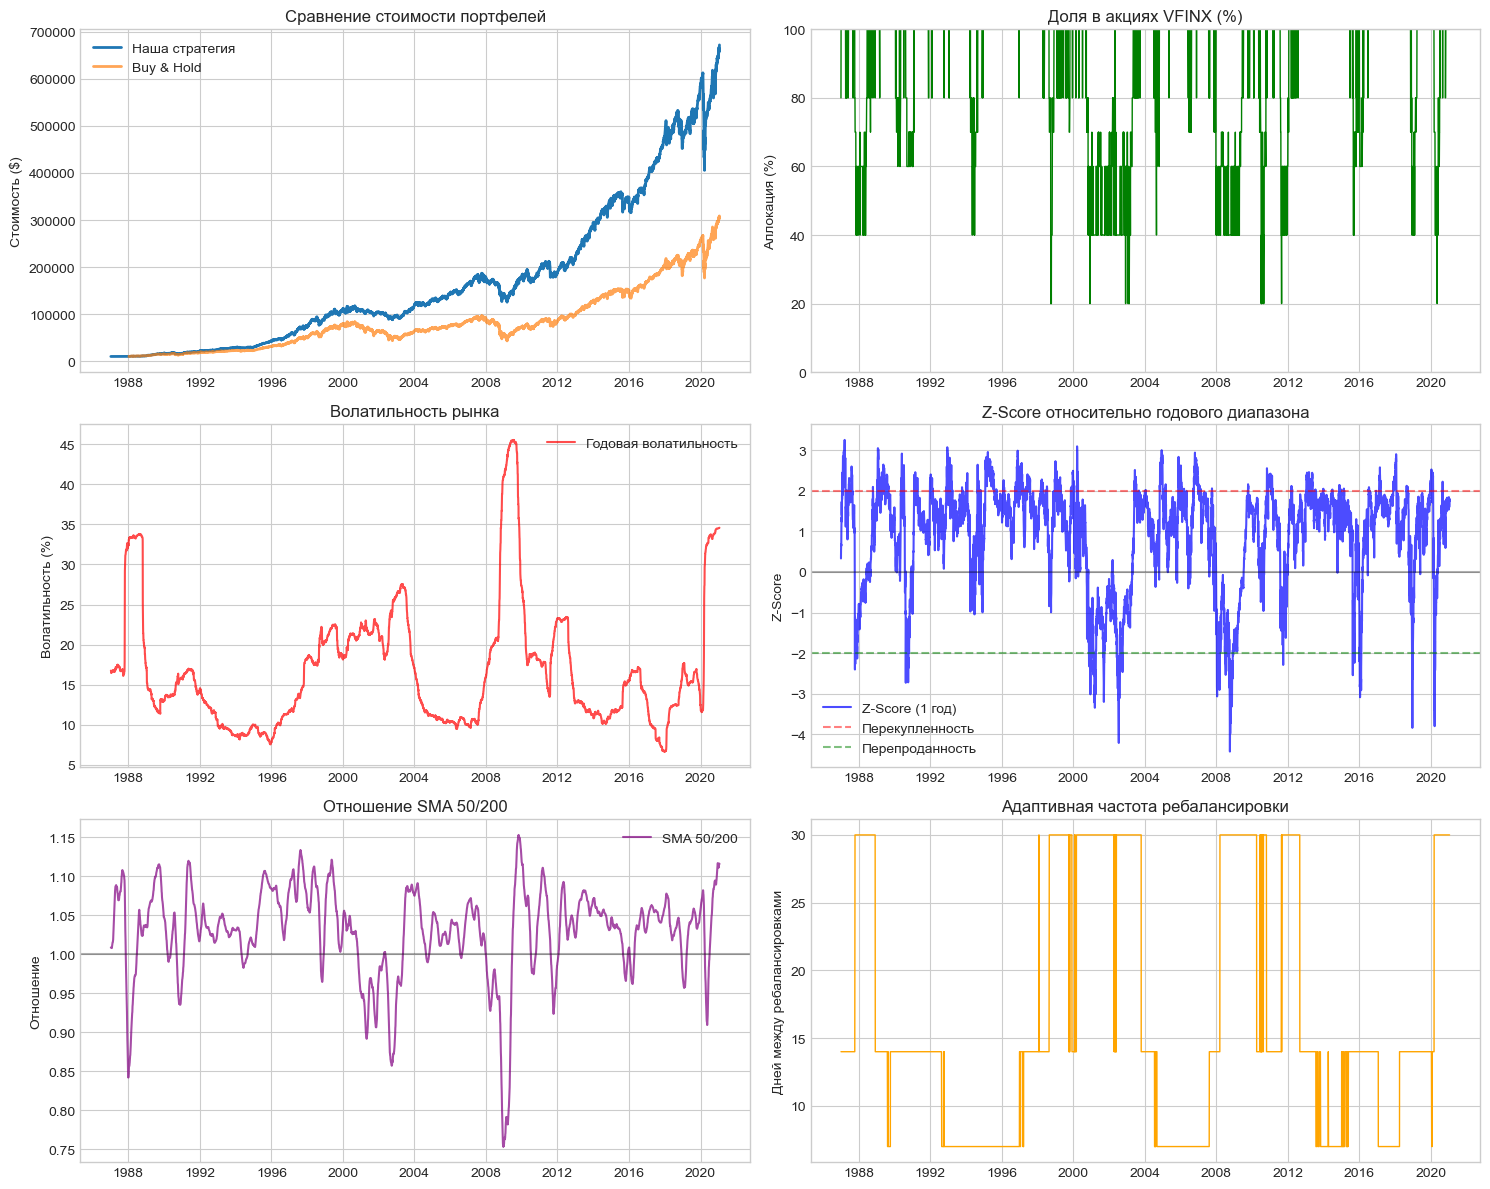

In [105]:
#Визуализация результатов

plt.figure(figsize=(15, 12))

# 1. Сравнение стоимостей портфелей
plt.subplot(3, 2, 1)
benchmark_value = 10000 * (1 + data_clean['Price'].iloc[252:].pct_change().fillna(0)).cumprod()
plt.plot(portfolio_results.index, portfolio_results['Total_Value'], 
         label='Наша стратегия', linewidth=2)
plt.plot(benchmark_value.index, benchmark_value, 
         label='Buy & Hold', linewidth=2, alpha=0.7)
plt.title('Сравнение стоимости портфелей')
plt.ylabel('Стоимость ($)')
plt.legend()
plt.grid(True)

# 2. Аллокация во времени
plt.subplot(3, 2, 2)
plt.plot(portfolio_results.index, portfolio_results['Allocation'] * 100, 
         linewidth=1, color='green')
plt.title('Доля в акциях VFINX (%)')
plt.ylabel('Аллокация (%)')
plt.ylim(0, 100)
plt.grid(True)

# 3. Волатильность
plt.subplot(3, 2, 3)
plt.plot(data_clean.index, data_clean['Volatility_1Y'] * 100, 
         label='Годовая волатильность', color='red', alpha=0.7)
plt.title('Волатильность рынка')
plt.ylabel('Волатильность (%)')
plt.legend()
plt.grid(True)

# 4. Z-Score
plt.subplot(3, 2, 4)
plt.plot(data_clean.index, data_clean['Z_Score_1Y'], 
         label='Z-Score (1 год)', color='blue', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=2, color='red', linestyle='--', alpha=0.5, label='Перекупленность')
plt.axhline(y=-2, color='green', linestyle='--', alpha=0.5, label='Перепроданность')
plt.title('Z-Score относительно годового диапазона')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)

# 5. Отношение скользящих средних
plt.subplot(3, 2, 5)
plt.plot(data_clean.index, data_clean['MA_Ratio_50_200'], 
         label='SMA 50/200', color='purple', alpha=0.7)
plt.axhline(y=1, color='black', linestyle='-', alpha=0.3)
plt.title('Отношение SMA 50/200')
plt.ylabel('Отношение')
plt.legend()
plt.grid(True)

# 6. Частота ребалансировки
plt.subplot(3, 2, 6)
freq_map = {'W': 7, '2W': 14, 'M': 30}
portfolio_results['Rebalance_Days'] = portfolio_results['Rebalance_Freq'].map(freq_map)
plt.plot(portfolio_results.index, portfolio_results['Rebalance_Days'], 
         linewidth=1, color='orange')
plt.title('Адаптивная частота ребалансировки')
plt.ylabel('Дней между ребалансировками')
plt.grid(True)

plt.tight_layout()
plt.show()


In [111]:
# Анализ устойчивости по подпериодам

def analyze_subperiods(portfolio_data, benchmark_data, rf_rate):
    """Анализ эффективности по подпериодам"""
    periods = {
        '1995-2000': ('1995-01-01', '2000-01-01'),
        '2000-2005': ('2000-01-01', '2005-01-01'),
        '2005-2010': ('2005-01-01', '2010-01-01'),
        '2010-2015': ('2010-01-01', '2015-01-01'),
        '2015-2020': ('2015-01-01', '2020-01-01')
    }
    
    print("АНАЛИЗ ПО ПОДПЕРИОДАМ:")
    print(f"{'Период':<12} {'CAGR':<10} {'Sharpe':<10} {'Max DD':<12} {'Аллокация':<12}")
    print("-" * 60)
    
    results = []
    
    for period, (start, end) in periods.items():
        try:
            # Обрезаем данные по периоду
            mask = (portfolio_data.index >= start) & (portfolio_data.index < end)
            sub_portfolio = portfolio_data[mask]
            sub_benchmark = benchmark_data[(benchmark_data.index >= start) & (benchmark_data.index < end)]
            
            if len(sub_portfolio) > 252:
                # CAGR стратегии
                sub_returns = sub_portfolio['Total_Value'].pct_change().dropna()
                sub_cagr = (sub_portfolio['Total_Value'].iloc[-1] / sub_portfolio['Total_Value'].iloc[0]) ** (252/len(sub_returns)) - 1
                
                # Коэффициент Шарпа
                sub_excess = sub_returns - rf_rate.reindex(sub_returns.index).fillna(0)
                sub_sharpe = sub_excess.mean() * 252 / (sub_returns.std() * np.sqrt(252))
                
                # Максимальная просадка
                cumulative = (1 + sub_returns).cumprod()
                running_max = cumulative.expanding().max()
                drawdown = (cumulative - running_max) / running_max
                sub_max_dd = drawdown.min()
                
                # Средняя аллокация
                avg_allocation = sub_portfolio['Allocation'].mean()
                
                print(f"{period:<12} {sub_cagr:>8.2%} {sub_sharpe:>9.2f} {sub_max_dd:>11.2%} {avg_allocation:>11.1%}")
                
                results.append({
                    'period': period,
                    'cagr': sub_cagr,
                    'sharpe': sub_sharpe,
                    'max_dd': sub_max_dd,
                    'allocation': avg_allocation
                })
        except Exception as e:
            continue
    
    return results

subperiod_results = analyze_subperiods(portfolio_results, data_clean['Price'], rf_daily)

АНАЛИЗ ПО ПОДПЕРИОДАМ:
Период       CAGR       Sharpe     Max DD       Аллокация   
------------------------------------------------------------
1995-2000      30.25%      1.40     -19.20%       96.6%
2000-2005       3.72%     -0.02     -25.17%       73.1%
2005-2010       6.21%      0.20     -32.82%       84.4%
2010-2015      13.59%      0.83     -16.13%       91.5%
2015-2020      11.35%      0.75     -15.18%       94.4%
